Based on Diagnosing and Enhancing VAE. 
1st Stage : Reconstruction 
- X -> Z -> X'
- Even if the reconstruction is very good, the distribution of X is not well estimated (because of the latent space not regularised enough)
- Latent space is not close enough to a N(0,1), but if it's closer, the reconstruction is very bad

2nd Stage : forcing the latent space to be close to a N(0,1)
- Z -> U -> Z'
- With the first stage, we are sure the reconstuction is good 
- The second stage focus on imporving the generation by mapping Z to U wich is closer to a N(0,1)

Generation :
- Sampling U -> Z' -> X'

Important : the two stages have to be trained separatly  

In [1]:
import altair as alt

from deep_traffic_generation.tcvae import TCVAE
from deep_traffic_generation.core.datasets import TrafficDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import pyvinecopulib as pv

import matplotlib.pyplot as plt
import numpy as np

from traffic.core import Traffic
from traffic.core.projection import EuroPP

import torch

from deep_traffic_generation.core.utils import traffic_from_data

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
np.random.seed(42)

# First Stage

In [2]:
dataset = TrafficDataset.from_file(
    "../../deep_traffic_generation/data/traffic_noga_tilFAF.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)
dataset

Dataset TrafficDataset
    Number of datapoints: 14399
    MinMaxScaler(feature_range=(-1, 1))

In [3]:
from os import walk

filenames = next(walk("../../deep_traffic_generation/lightning_logs/tcvae/version_8/checkpoints"), (None, None, []))[2]

FirstStage = TCVAE.load_from_checkpoint(
    "../../deep_traffic_generation/lightning_logs/tcvae/version_8/checkpoints/" + filenames[0],
    hparams_file="../../deep_traffic_generation/lightning_logs/tcvae/version_8/hparams.yaml",
    dataset_params=dataset.parameters,
)
FirstStage.eval()

TCVAE(
  (encoder): Sequential(
    (0): TCN(
      (network): Sequential(
        (0): ResidualBlock(
          (tmp_block1): TemporalBlock(
            (conv): Conv1d(4, 64, kernel_size=(16,), stride=(1,))
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (tmp_block2): TemporalBlock(
            (conv): Conv1d(64, 64, kernel_size=(16,), stride=(1,))
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (downsample): Conv1d(4, 64, kernel_size=(1,), stride=(1,))
        )
        (1): ResidualBlock(
          (tmp_block1): TemporalBlock(
            (conv): Conv1d(64, 64, kernel_size=(16,), stride=(1,), dilation=(2,))
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (tmp_block2): TemporalBlock(
            (conv): Conv1d(64, 64, kernel_size=(16,), stride=(1,), dilation=(2,))
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (2): ResidualBlock(
          (tmp_block1): TemporalBlock(


In the original paper, there are no scaling of the data for the second stage

In [4]:
# Latent Space

h = FirstStage.encoder(dataset.data)
q = FirstStage.lsr(h)
z = q.rsample()
input_SecondStage = z.detach().cpu()

In [37]:
# input_SecondStage.mean(axis = 0)
# input_SecondStage.std(axis = 0)

In [5]:
# #Ajouter une normalisation éventuelle
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(-1, 1))
input_SecondStage = torch.Tensor(scaler.fit_transform(input_SecondStage))

In [6]:
from deep_traffic_generation.core.utils import get_dataloaders

SecondStage_train_loader, SecondStage_val_loader, SecondStage_test_loader = get_dataloaders(
        input_SecondStage,
        0.8, #train_ratio
        0.2, #val_ratio
        200, #batch_size
        200, #test_batch_size
    )

# Second Stage

## FCVAE 

Essayer éventuellement de prédire la log std au lieu de la std dans le décoder

In [7]:
from typing import Dict, Tuple, Union
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from torch.distributions.distribution import Distribution
import torch
from deep_traffic_generation.core import GaussianMixtureLSR, VAE, FCN

#On refabrique un VAE à la main car la pipline du porjet est fait pour traiter spécifiquement des traffics (avec DatasetParams)

class SecondStage_VAE(pl.LightningModule):
    def __init__(self, 
        input_dim = 256, 
        latent_dim=256,
        h_dims = [1024,1024,1024], #gives dimensions of hidden layers + dimensions of output of encoder
        h_activ = nn.ReLU(), 
        batch_norm = True,
        ):
        super().__init__()

        self.save_hyperparameters()

        #Convolutional layers

        # encoder, decoder
        self.encoder = FCN(
            input_dim=input_dim,
            out_dim=h_dims[-1],
            h_dims=h_dims[:-1],
            batch_norm=batch_norm,
            h_activ = h_activ,
            dropout=0.2,
        )

        self.decoder = FCN(
            input_dim=latent_dim,
            out_dim=input_dim,
            h_dims=h_dims[::-1],
            batch_norm=batch_norm,
            h_activ = h_activ,
            dropout=0.2,
        )

        # distribution parameters
        self.lsr = GaussianMixtureLSR(
            input_dim=h_dims[-1],
            out_dim=latent_dim,
            n_components=1,
        )

        self.out_activ = nn.Tanh()

        # for the gaussian likelihood
        self.scale = nn.Parameter(torch.Tensor([1.0]))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma = 0.5)
        return {"optimizer" : optimizer, "scheduler" : scheduler}

    def gen_loss(
        self, x: torch.Tensor, x_hat: torch.Tensor, gamma: torch.Tensor
    ):
        """Computes generation loss in TwoStages VAE Model
        Args :
            x : input data
            x_hat : reconstructed data
            gamma : decoder std (scalar as every distribution in the decoder has the same std)

        To use it within the learning : take the sum and divide by the batch size
        """
        HALF_LOG_TWO_PI = 0.91893

        loggamma = torch.log(gamma)
        return (
            torch.square((x - x_hat) / gamma) / 2.0 + loggamma + HALF_LOG_TWO_PI
        )

    def kl_loss(self, mu: torch.Tensor, std: torch.Tensor):
        """Computes close form of KL for gaussian distributions
        Args :
            mu : encoder means
            std : encoder stds

        To use it within the learning : take the sum and divide by the batch size
        """
        logstd = torch.log(std)
        return (torch.square(mu) + torch.square(std) - 2 * logstd - 1) / 2.0

    def forward(self, x) -> Tuple[Tuple, torch.Tensor, torch.Tensor]:
        # encode x to get the location and log variance parameters
        h = self.encoder(x)
        q = self.lsr(h)
        z = q.rsample()
        # decode z
        # x_hat = self.out_activ(self.decoder(z))
        x_hat = self.decoder(z)
        return self.lsr.dist_params(q), z, x_hat

    def training_step(self, batch, batch_idx):
        x = batch
        batch_size = x.shape[0]
        dist_params, z, x_hat = self.forward(x)

         # std of decoder distribution (init at 1)
        # self.scale = nn.Parameter(
        #     torch.Tensor([torch.sqrt(F.mse_loss(x, x_hat))]),
        #     requires_grad=False,
        # )
        gamma = self.scale

        #Loss computation
        kld_loss = (
            torch.sum(self.kl_loss(dist_params[1], dist_params[2])) / batch_size
        )
        llv_loss = torch.sum(self.gen_loss(x, x_hat, gamma)) / batch_size

        elbo = kld_loss + llv_loss

        self.log_dict({
            'elbo': elbo,
            'kl': kld_loss,
            'recon_loss': llv_loss,
        })

        return elbo

    def validation_step(self, batch, batch_idx):
        x = batch
        _, _, x_hat = self.forward(x)
        loss = F.mse_loss(x_hat, x)
        self.log("hp/valid_loss", loss)

    def test_step(self, batch, batch_idx):
        x, info = batch
        _, _, x_hat = self.forward(x)
        loss = F.mse_loss(x_hat, x)
        self.log("hp/test_loss", loss)
        return x, x_hat, info


In [22]:
class VAE(pl.LightningModule):
    def __init__(self, 
        input_dim = 256, 
        latent_dim=256,
        h_dims = [512,1024,512], #gives dimensions of hidden layers + dimensions of output of encoder
        h_activ = nn.ReLU(), 
        batch_norm = False,
        ):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = FCN(
            input_dim=input_dim,
            out_dim=h_dims[-1],
            h_dims=h_dims[:-1],
            batch_norm=batch_norm,
            h_activ = h_activ,
            dropout=0.2,
        )

        self.decoder = FCN(
            input_dim=latent_dim,
            out_dim=input_dim,
            h_dims=h_dims[::-1],
            batch_norm=batch_norm,
            h_activ = h_activ,
            dropout=0.2,
        )

        # distribution parameters
        self.fc_mu = nn.Linear(h_dims[-1], latent_dim)
        self.fc_var = nn.Linear(h_dims[-1], latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma = 0.5)
        return {"optimizer" : optimizer, "scheduler" : scheduler}

    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum()

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        self.loc = mu
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

In [21]:
SecondStage.loc

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<AddmmBackward>)

In [23]:
torch.manual_seed(42)

SecondStage = VAE()
trainer = pl.Trainer(gpus=0, max_epochs=2000, progress_bar_refresh_rate=1)
trainer.fit(SecondStage, SecondStage_train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | encoder | FCN    | 1.2 M 
1 | decoder | FCN    | 1.3 M 
2 | fc_mu   | Linear | 131 K 
3 | fc_var  | Linear | 131 K 
-----------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.030    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

In [54]:
torch.manual_seed(42)

SecondStage = SecondStage_VAE()
trainer = pl.Trainer(gpus=0, max_epochs=1000, progress_bar_refresh_rate=1)
trainer.fit(SecondStage, SecondStage_train_loader)#, SecondStage_val_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | FCN                | 2.4 M 
1 | decoder   | FCN                | 2.6 M 
2 | lsr       | GaussianMixtureLSR | 526 K 
3 | out_activ | Tanh               | 0     
-------------------------------------------------
5.5 M     Trainable params
513       Non-trainable params
5.5 M     Total params
22.054    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

# Reconstruction through 2 stages

- La version 12 avec batch norm + 256 256 256 n'est pas très performante malgré une meilleure loss
- La version 11 sans batch norm + 128 128 128 marche assez bien 
- Au lieu de passer directement à la génération, regarder comment se comporte la reconstruction en passant par le 2 stages VAE

In [91]:
from os import walk

filenames = next(walk("lightning_logs/version_10/checkpoints"), (None, None, []))[2]

# SecondStage = SecondStage_VAE.load_from_checkpoint(
#     "lightning_logs/version_10/checkpoints/" + filenames[0], 
#     hparams_file="lightning_logs/version_10/hparams.yaml",
# )

SecondStage = VAE.load_from_checkpoint(
    "lightning_logs/version_10/checkpoints/" + filenames[0], 
    hparams_file="lightning_logs/version_10/hparams.yaml",
)

SecondStage.eval()

VAE(
  (encoder): FCN(
    (layers): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=1024, out_features=1024, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=1024, out_features=1024, bias=True)
    )
  )
  (decoder): FCN(
    (layers): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=1024, out_features=1024, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=1024, out_features=1024, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.2, inplace=False)
      (9): Linear(in_features=1024, out_features=256, bias=True)
    )
  )
  (fc_mu): Linear(in_features=1024, out_features=256, bias=True)
  (fc_var): Linear(in_features=1024, out_features=256, bias=True)
)

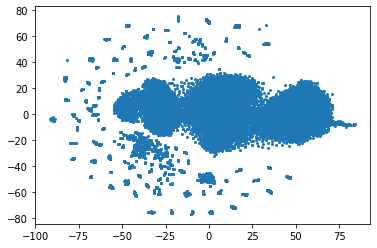

In [92]:
#First Stage encoding
h_1 = FirstStage.encoder(dataset.data)
q_1 = FirstStage.lsr(h_1)
z_1 = q_1.rsample()
z_1 = z_1.detach().cpu()

#second Stage encoding
# z_2 = torch.Tensor(scaler.transform(z_1))
# z_2 = z_1
# h_2 = SecondStage.encoder(z_2)
# q_2 = SecondStage.lsr(h_2)
# u = q_2.rsample()
# u = u.detach().cpu()

#second Stage encoding
z_2 = torch.Tensor(scaler.transform(z_1))
h_2 = SecondStage.encoder(z_2)

mu = SecondStage.fc_mu(h_2)
std = torch.exp(SecondStage.fc_var(h_2) / 2)
q_2 = torch.distributions.Normal(mu, std)

u = q_2.rsample()
u = u.detach().cpu()

u_embedded = TSNE(n_components=2).fit_transform(u.numpy())
plt.scatter(u_embedded[:, 0], u_embedded[:, 1], s=4)
plt.show()

ATTENTION a la reconstruction des Z après le second stage

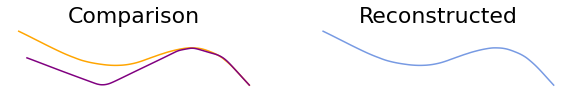

In [94]:
### Reconstruction
i = np.random.randint(len(dataset))
original, info = dataset[i]
p_u = torch.distributions.Normal(torch.zeros(256), torch.ones(256))

reco_z = SecondStage.decoder(u[i].unsqueeze(0).to(SecondStage.device)).cpu()
# reco_z = reco_z + SecondStage.scale*p_u.rsample()
# reco_z = reco_z + torch.exp(SecondStage.log_scale)*p_u.rsample()
reco_z = torch.Tensor(scaler.inverse_transform(reco_z.detach()))
reco_x = FirstStage.decoder(reco_z)

data = torch.cat((original.unsqueeze(0).transpose(1, 2), reco_x.detach().transpose(1, 2)))
data = data.view((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

#add lat/lon info
info = info.repeat(2, 1)
data = np.concatenate((info.numpy(), data), axis=1)

builder = FirstStage.get_builder(data.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in FirstStage.hparams.features
]

reconstruction = traffic_from_data(
    data, features, FirstStage.dataset_params["info_params"]["features"], builder=builder
)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Comparison")
    reconstruction[1].plot(ax[0], c="orange", label="reconstructed")
    reconstruction[0].plot(ax[0], c="purple", label="original")
    ax[1].set_title("Reconstructed")
    reconstruction[1].plot(ax[1])

    plt.show()

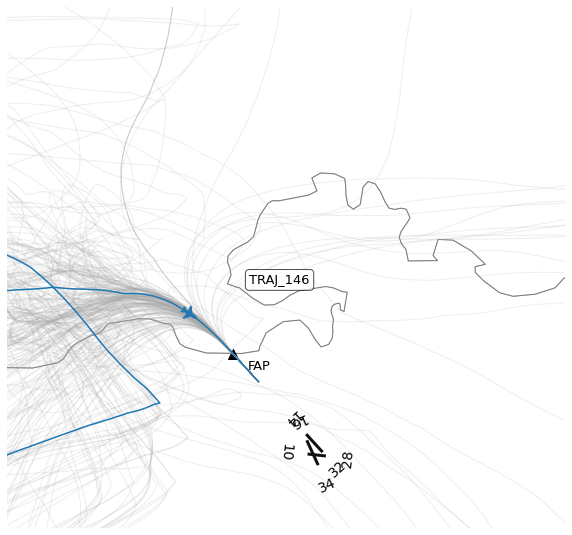

In [99]:
import matplotlib.pyplot as plt
from traffic.core.projection import CH1903p, EuroPP
from traffic.drawing import countries
from traffic.data import airports
from traffic.data import navaids

n_disp = 200
p_u = torch.distributions.Normal(torch.zeros(256), torch.ones(256))

### Reconstruction
with torch.no_grad():
    reco_z = SecondStage.decoder(u[:n_disp].to(SecondStage.device)).cpu()
    # reco_z = reco_z + SecondStage.scale*p_u.rsample((len(reco_z),))
    # reco_z = reco_z + torch.exp(SecondStage.log_scale)*p_u.rsample((len(reco_z),))
    reco_z = torch.Tensor(scaler.inverse_transform(reco_z))
    reco_x = FirstStage.decoder(reco_z)

reco_x = reco_x.detach().transpose(1,2).reshape(reco_x.shape[0],-1)
data_reco = dataset.scaler.inverse_transform(reco_x)

_, info = dataset[0] #lat/lon info from original dataset
info = info.repeat(len(data_reco), 1)
data_reco = np.concatenate((info.numpy(), data_reco), axis=1)

builder = FirstStage.get_builder(data_reco.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in FirstStage.hparams.features
]

reconstruction = traffic_from_data(
    data_reco, features, FirstStage.dataset_params["info_params"]["features"], builder=builder
)

i = np.random.randint(len(reconstruction))


with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((8, 9, 47.37, 48))

    reconstruction.plot(ax, alpha=0.2)
    reconstruction[i].plot(ax, color="#1f77b4", lw=1.5)
    reconstruction[i].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )
    
    navaids["OSNEM"].plot(
        ax,
        zorder=2,
        marker="^",
        shift=dict(units="dots", x=15, y=-15),
        text_kw={
            "s": "FAP",
        },
    )

# Generation

In [100]:
# U COMES FROM NORMAL(0, 1) (Sampling within the 2nd stage)
num_preds = 1000
p_u = torch.distributions.Normal(torch.zeros(256), torch.ones(256))
u = p_u.rsample((num_preds,))

# SAMPLE IMAGES
with torch.no_grad():
    gen_z = SecondStage.decoder(u.to(SecondStage.device)).cpu()
    gen_z = torch.Tensor(scaler.inverse_transform(gen_z))
    gen_x = FirstStage.decoder(gen_z)

gen_x = gen_x.detach().transpose(1,2).reshape(gen_x.shape[0],-1)
data_gen = dataset.scaler.inverse_transform(gen_x)

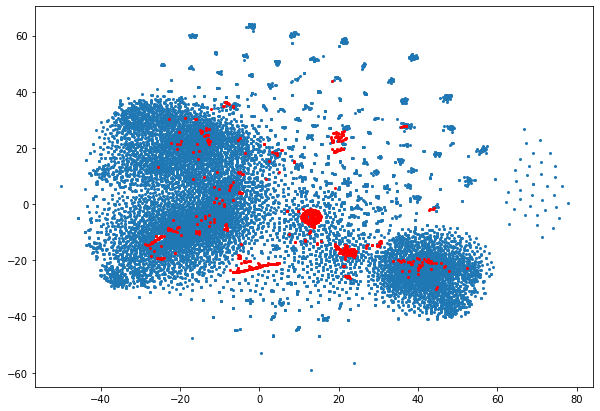

In [101]:
h = FirstStage.encoder(dataset.data)
q = FirstStage.lsr(h)
z = q.rsample()
z = z.detach().cpu().numpy()


encodings = np.concatenate((z, gen_z), axis=0)
# encodings = z
encodings_embedded = TSNE(n_components=2).fit_transform(encodings)

fig, ax = plt.subplots(1, figsize=(10, 7))
ax.scatter(encodings_embedded[:-num_preds, 0], encodings_embedded[:-num_preds, 1], s=4)
ax.scatter(encodings_embedded[-num_preds:, 0], encodings_embedded[-num_preds:, 1], s=4, c='red')
# ax.scatter(encodings_embedded[:, 0], encodings_embedded[:, 1], s=4)
plt.show()

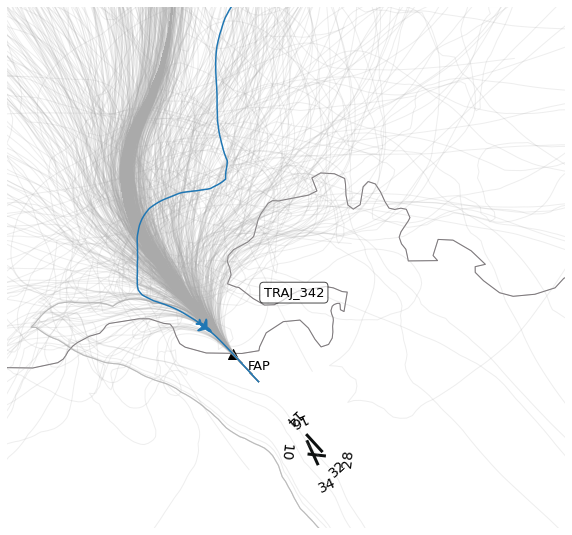

In [102]:
import matplotlib.pyplot as plt
from traffic.core.projection import CH1903p, EuroPP
from traffic.drawing import countries
from traffic.data import airports
from traffic.data import navaids

# add latitude longitude info
_, info = dataset[0] #lat/lon info from original dataset
info = info.repeat(num_preds, 1)
data_gen = np.concatenate((info.numpy(), data_gen), axis=1)

builder = FirstStage.get_builder(data_gen.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in FirstStage.hparams.features
]
generation = traffic_from_data(
    data_gen, features, FirstStage.dataset_params["info_params"]["features"], builder=builder
)

i = np.random.randint(len(generation))


with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((8, 9, 47.37, 48))

    generation.plot(ax, alpha=0.2)
    generation[i].plot(ax, color="#1f77b4", lw=1.5)
    generation[i].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )
    
    navaids["OSNEM"].plot(
        ax,
        zorder=2,
        marker="^",
        shift=dict(units="dots", x=15, y=-15),
        text_kw={
            "s": "FAP",
        },
    )

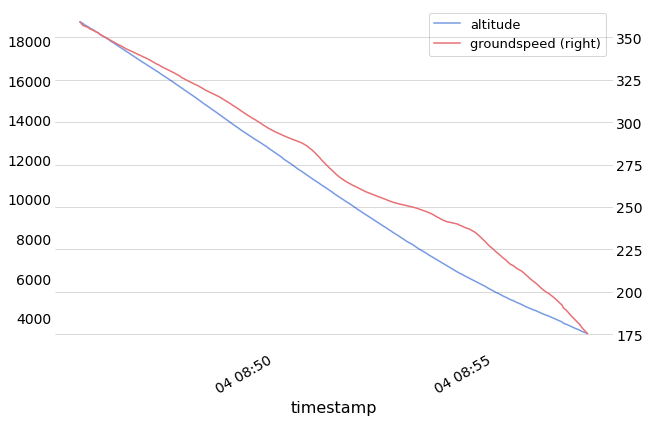

In [104]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(figsize=(10, 7))
    generation[int(i)].plot_time(
        ax, y=["altitude", "groundspeed"], secondary_y=["groundspeed"]
    )

In [14]:
test = generation.cumulative_distance().eval()

In [15]:
test.data[["flight_id", "cumdist"]].groupby(["flight_id"]).max().sort_values(by="cumdist")

,cumdist
flight_id,
TRAJ_714,17.717325
TRAJ_707,18.150383
TRAJ_84,18.422551
TRAJ_102,20.562585
TRAJ_680,20.801644
...,...
TRAJ_487,87.401482
TRAJ_32,87.636900
TRAJ_836,92.934982


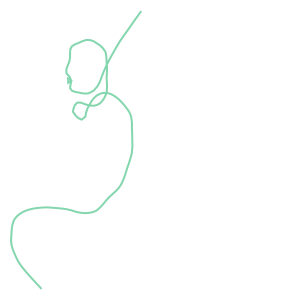

In [28]:
f = test["TRAJ_969"]
f

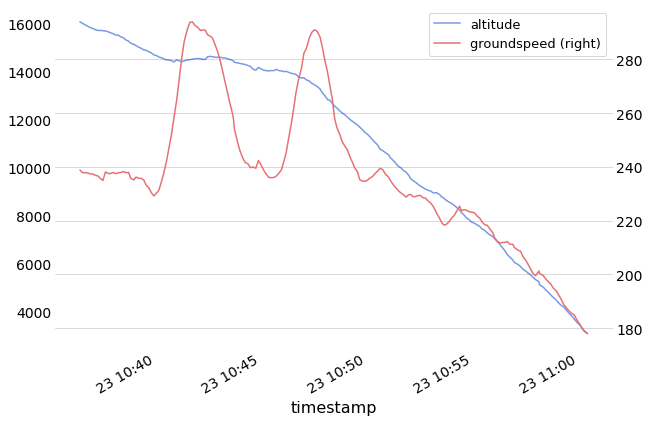

In [29]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(figsize=(10, 7))
    f.plot_time(
        ax, y=["altitude", "groundspeed"], secondary_y=["groundspeed"]
    )